# Inspired from work by Jencka and Adams

In [96]:
import pandas as pd
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe

In [97]:
header = ("X", "Y", "Z", "TIME", "SLURM_NNODES", "SLURM_NTASKS_PER_NODE", "OMP_NUM_THREADS", "SLURM_GPUS_PER_NODE", "GFLOPS")

In [120]:
dat_hopper = pd.read_csv('global_results.csv', names=header)
dat_hopper['Cluster'] = 'Hopper'
dat_hopper.loc[dat_hopper['SLURM_GPUS_PER_NODE'] > 0, 'Cluster'] = "Hopper (GPU)"

In [121]:
data = pd.concat((dat_hopper,))
data

,X,Y,Z,TIME,SLURM_NNODES,SLURM_NTASKS_PER_NODE,OMP_NUM_THREADS,SLURM_GPUS_PER_NODE,GFLOPS,Cluster
0,8,8.0,8.0,90.0,4.0,1.0,1.0,1.0,5.508880,Hopper (GPU)
1,8,8.0,32.0,90.0,4.0,1.0,1.0,1.0,10.878000,Hopper (GPU)
2,8,8.0,40.0,90.0,1.0,1.0,1.0,1.0,4.249110,Hopper (GPU)
3,8,8.0,56.0,90.0,1.0,1.0,1.0,1.0,5.731480,Hopper (GPU)
4,8,8.0,8.0,90.0,1.0,1.0,1.0,1.0,1.697070,Hopper (GPU)
...,...,...,...,...,...,...,...,...,...,...
3169,16,56.0,80.0,90.0,2.0,32.0,1.0,0.0,0.520269,Hopper
3170,56,32.0,40.0,90.0,1.0,1.0,2.0,0.0,1.721790,Hopper
3171,56,32.0,48.0,90.0,1.0,1.0,2.0,0.0,1.664270,Hopper
3172,32,56.0,8.0,90.0,1.0,16.0,1.0,0.0,0.154390,Hopper


In [122]:
data['Process Count'] = data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'] * data['OMP_NUM_THREADS']
set(data['Process Count'])

{1.0, 2.0, 4.0, 16.0, 32.0, 64.0, nan, 128.0}

In [123]:
data['Problem Size'] = data['X'] * data['Y'] * data['Z']
print(data['Problem Size'].max() ** (1.0 / 3.0))

data['Global Problem Size'] = data['Problem Size'] * (data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])
print(data['Global Problem Size'].max() ** (1.0 / 3.0))

82.30621182481418
166.15981125923528


In [124]:
data['SLURM_GPUS_PER_NODE'].max()

1.0

In [125]:
data['OMP_NUM_THREADS'].max()

2.0

# Plots

In [126]:
def label_peaks(df, groupby, value, troughs=False):
    mean = df.groupby(groupby).mean(numeric_only=True)[value]
    idx, _ = signal.find_peaks(mean)
    peaks = mean.iloc[idx]

    if troughs:
        idx, _ = signal.find_peaks(-mean)
        peaks = pd.concat((peaks, mean.iloc[idx]))

    for (x, y) in peaks.items():
        plt.text(x, y, str(x), path_effects=[pe.withStroke(linewidth=4, foreground="white")])

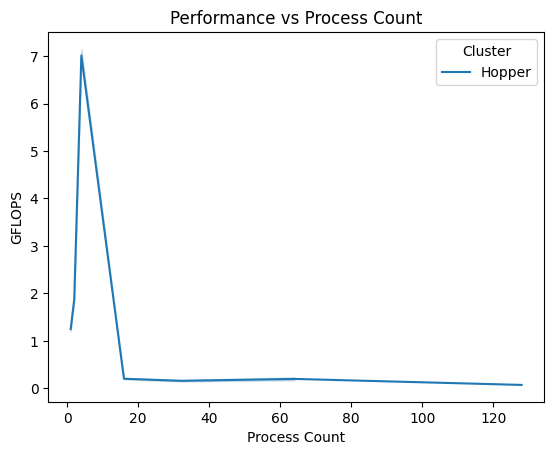

In [127]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count.svg')

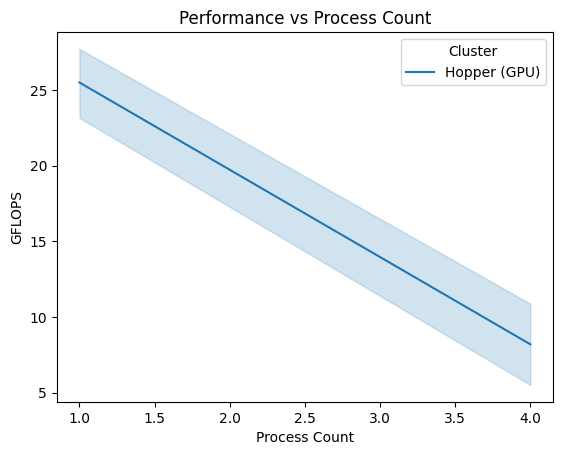

In [128]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count_gpu.svg')

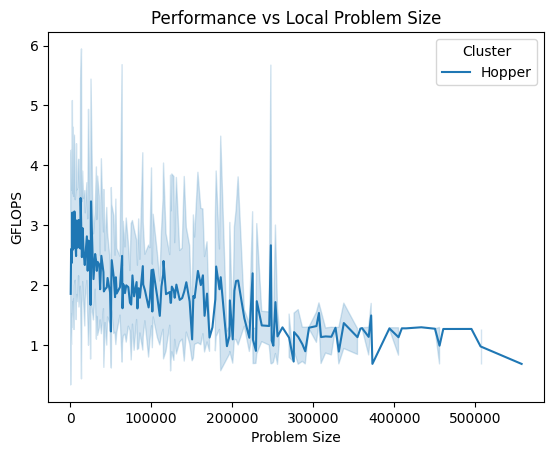

In [129]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Local Problem Size')
plt.savefig('figures/flops_local_problem_size.svg')

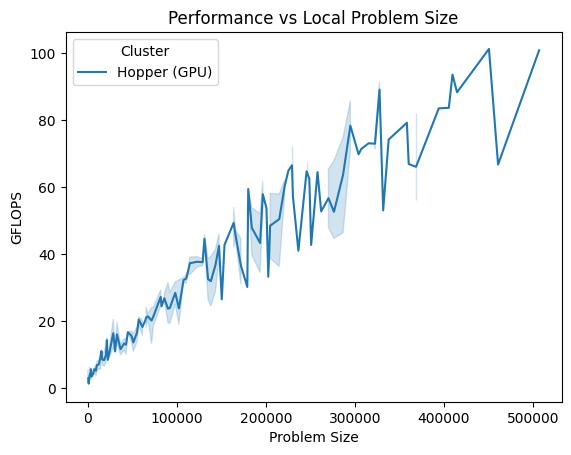

In [130]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Local Problem Size')
plt.savefig('figures/flops_local_problem_size_gpu.svg')

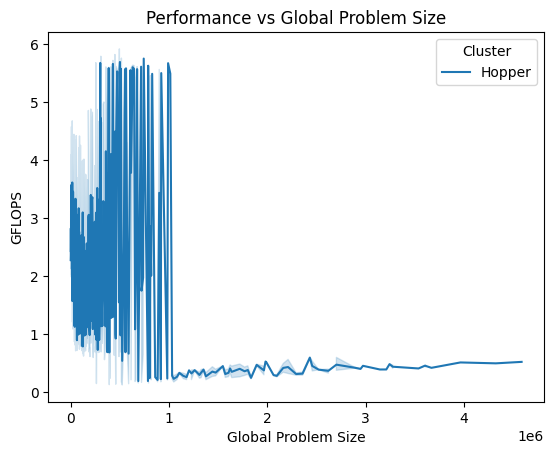

In [131]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Global Problem Size')
plt.savefig('figures/flops_global_problem_size.svg')

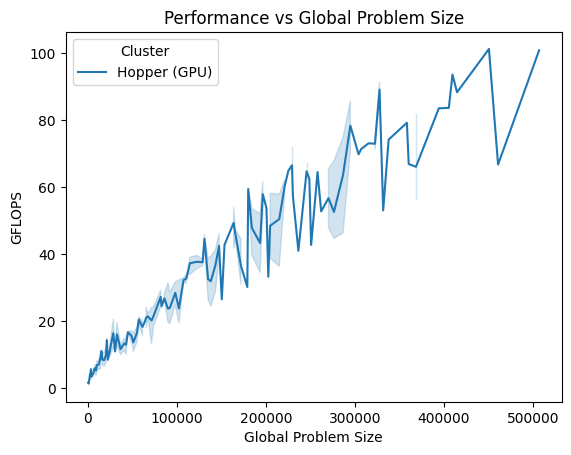

In [132]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Global Problem Size')
plt.savefig('figures/flops_global_problem_size_gpu.svg')

# Statistics

In [133]:
# Summary Stats for performance of ALL runs
stats_all_runs = data["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_all_runs

count    3173.000000
mean        4.966592
std        10.927629
min         0.019409
25%         0.700575
50%         1.616550
75%         5.524910
90%         9.056176
95%        22.141400
99%        62.390708
max       101.310000
Name: GFLOPS, dtype: float64

In [134]:
# Summary stats for Hopper
stats_hopper = data[data['Cluster'] == 'Hopper']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper

count    2793.000000
mean        2.184914
std         2.453714
min         0.019409
25%         0.687214
50%         1.313000
75%         2.432810
90%         6.205996
95%         8.392262
99%         9.114921
max         9.593380
Name: GFLOPS, dtype: float64

In [135]:
# Summary stats for Hopper (GPU)
stats_hopper_gpu = data[data['Cluster'] == 'Hopper (GPU)']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper_gpu

count    380.000000
mean      25.411926
std       21.884350
min        1.057620
25%        8.485800
50%       17.591450
75%       35.555200
90%       60.003210
95%       69.928320
99%       89.015614
max      101.310000
Name: GFLOPS, dtype: float64

In [136]:
# latex
print(pd.concat([stats_all_runs, stats_hopper, stats_hopper_gpu], axis=1).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &       GFLOPS &       GFLOPS &      GFLOPS \\
\midrule
count &  3173.000000 &  2793.000000 &  380.000000 \\
mean  &     4.966592 &     2.184914 &   25.411926 \\
std   &    10.927629 &     2.453714 &   21.884350 \\
min   &     0.019409 &     0.019409 &    1.057620 \\
25\%   &     0.700575 &     0.687214 &    8.485800 \\
50\%   &     1.616550 &     1.313000 &   17.591450 \\
75\%   &     5.524910 &     2.432810 &   35.555200 \\
90\%   &     9.056176 &     6.205996 &   60.003210 \\
95\%   &    22.141400 &     8.392262 &   69.928320 \\
99\%   &    62.390708 &     9.114921 &   89.015614 \\
max   &   101.310000 &     9.593380 &  101.310000 \\
\bottomrule
\end{tabular}



# Gustafson's like

In [137]:
one_thread = data[data['OMP_NUM_THREADS'] == 1]

In [141]:
past_2e6 = one_thread[one_thread['Global Problem Size'] > 2e6]

In [145]:
pre_2e6 = one_thread[one_thread['Global Problem Size'] < 2e6]

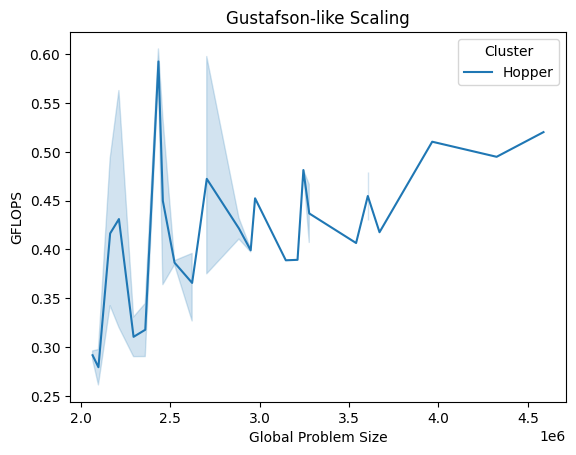

In [142]:
sns.lineplot(past_2e6[past_2e6['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson.svg')

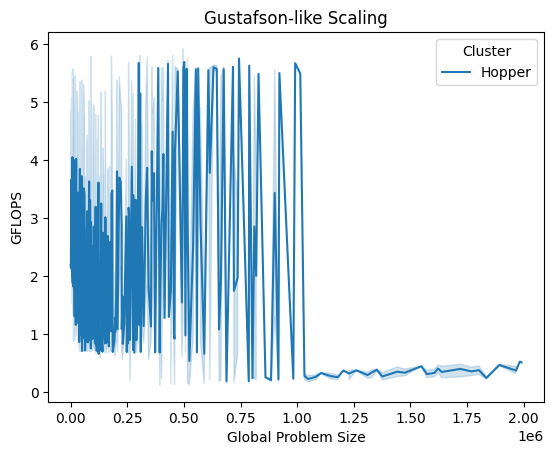

In [146]:
sns.lineplot(pre_2e6[pre_2e6['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson.svg')